# **TCC PUC MINAS**
### A opinião pública sobre a RFB - Análise de sentimentos de tweets
##### Grasiela Peccini

## Importação dos pacotes necessários

In [2]:
import tweepy
import time
import pandas as pd
import csv
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Coleta de dados
Os datasets coletados via API do Twitter foram obtidos com variações do código que segue. No exemplo, está a coleta dos textos relativos aos identificadores do dataset TASH.

In [ ]:
#dados necessários para a conexão à API do Twitter. Os valores XXX devem ser substituídos pelas credenciais do usuário
consumer_key = 'XXX'
consumer_secret = 'XXX'
token_key = 'XXX'
token_secret = 'XXX'

def download_tweets(id_file):
    #arquivo para gravação dos dados extraídos
    tash_path='D:/Pos_PUC/TCC/Datasets/tash_texto_completo.csv'
    #arquivo para registrar tweets com erro de download
    tash_error_path='D:/Pos_PUC/TCC/Datasets/tash_error_completo.csv'
    #abertura dos arquivos para gravação, com codificação UTF-8
    tash_file=open(tash_path,"w", encoding='utf8')
    tash_error=open(tash_error_path,"w", encoding='utf8')
    #para cada id do arquivo, extrai o tweet, trata e grava no arquivo
    with open(id_file) as infile:
        for tweet_id in infile:
            tweet_id = tweet_id.strip()

            try:

                tweet = api.get_status(tweet_id, tweet_mode="extended", start_time="2006-03-21T00:00:00Z")
                texto=tweet.full_text.replace("\"","")
                texto=texto.replace(";","")
                print(tweet.full_text)
                tash_file.write(str(tweet.id)+";\""+texto+"\"\n")
                
            except tweepy.error.TweepError:
                print("tweet com id: ", tweet_id, "não está disponível")
                tash_error.write(str(tweet.id)+"\n")

            time.sleep(1)
    tash_file.close
    tash_error.close


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(token_key, token_secret)
api = tweepy.API(auth)

download_tweets("D:/Pos_PUC/TCC/Datasets/tash-pt-master/id_file.txt")

## Split da base toRFB em treinamento e teste
Foram separados 5% da base para treinamento. Esses tweets foram manualmente classificados. Registros que possuiam apenas links, emoticons ou referências a usuários foram descartados.

In [ ]:
#carrega arquivo de tweets para a RFB
tw_rfb = pd.read_csv('D:/Pos_PUC/TCC/Datasets/toRFB_extract.csv', delimiter=";", encoding='utf-8')
tw_rfb.columns=['id', 'text', 'author_id', 'created_at']
index = tw_rfb[tw_rfb['author_id'] == 18718638].index #remove tweets da RFB
tw_rfb.drop(index, inplace=True)

#divide o conjunto em 5% e 95%
to_rfb_rotular=tw_rfb.sample(frac=0.05, random_state=0)
to_rfb_testar=tw_rfb.drop(to_rfb_rotular.index)
to_rfb_rotular.to_csv("D:/Pos_PUC/TCC/Datasets/Treinamento/toRFB_treino.csv")
to_rfb_testar.to_csv("D:/Pos_PUC/TCC/Datasets/Teste/toRFB_teste.csv")

## Merge da base de treinamento
Processo realizado na ferramenta de escritório Calc (LibreOffice). Produzido o arquivo toRFB_e_Mg.csv.

# Carga da base de treinamento

In [178]:
#carrega o dataset de treinamento para o dataframe df_treinamento
df_treinamento = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Datasets_Final/toRFB_e_Mg.csv', encoding='utf-8')
#df_treinamento = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Datasets_Final/Tweets_Mg.csv', encoding='utf-8')
df_treinamento.columns=['text', 'sentiment']

In [65]:
#exibe amostra aletória de 10 registros da base de treinamento
with pd.option_context('display.max_colwidth', -1):     
  display(df_treinamento[['text', 'sentiment']].sample(n=10, random_state=4))

,text,sentiment
5933,"Contra febre amarela, vacinação é oferecida 'casa a casa' em Varginha https://t.co/8foULUoRSM https://t.co/OrndOrKwp5",1
7575,Suspeito de tráfico de drogas é detido com mais de R$ 22 mil em Juiz de Fora #G1 https://t.co/J4sKWkRr3n,1
5303,Escola do Legislativo é tema de mestrado na Universidade de Portugal https://t.co/owaT3FHztK #SuldeMinas https://t.co/kTaVxgT9Zs,1
7434,@PMMG190 - PM prende dupla por tráfico de drogas https://t.co/iOt2Dy9SBc,1
7055,Polícia Civil apresenta dupla presa por tráfico de drogas em Patrocínio https://t.co/ACoS7iSTH4 https://t.co/6TGcDP8BKZ,1
5187,"RT Ministério da Saúde liberou R$ 543,5 milhões ao estado de Minas Gerais.\nHospitais em Uberaba e Uberlândia estão entre os beneficiados.",1
724,"Crise? Q crise?! // Mesmo em calamidade financeira, governo de MG compra mais dois helicópteros @UOL https://t.co/c8K1KqJOjD",-1
6290,Grupo é detido após roubo e carreta recuperada em MG https://t.co/Q9vWjPEU2a #SomosTodosDilma #Raynniere #BuyRaynniereOnItunes,1
4022,"RT @radioitatiaia: Mesmo em 'calamidade financeira', governo de Minas compra mais dois helicópteros: https://t.co/9PMQRR5fn8 https://t.co/9…",-1
7872,"Dois homens são presos por tráfico de drogas em Japonvar, Norte de MG https://t.co/t7RDt62z58 https://t.co/4BaG2DEiE0",1


## Nuvem de palavras da base de treinamento (sem tratamento)

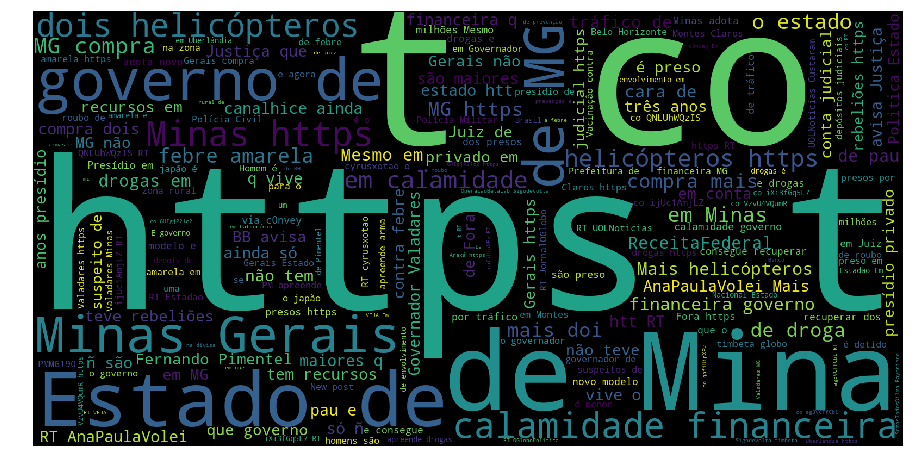

In [6]:
#especifica os parâmetros, gera a nuvem e exibe a imagem
def nuvem(string):
    wordcloud = WordCloud(background_color='black', width=1600, height=800).generate(string)
    fig, ax = plt.subplots(figsize=(16,8))            
    ax.imshow(wordcloud, interpolation='bilinear')       
    ax.set_axis_off()
    plt.imshow(wordcloud)
    plt.show()

#junta todo o conteúdo do dataframe em uma única string
all_content=' '.join(df_treinamento['text'])
nuvem(all_content)

## Definição das funções de tratamento de string

In [179]:
#substitui termos
def replace(string):
    string= re.sub('hahaha{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('hehehe{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('ahah{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('kkkah{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('kkkh{1,}?', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('k{2,}', 'kkk', string, flags=re.IGNORECASE)
    string= re.sub('ñ ', 'não ', string, flags=re.IGNORECASE)
    string= re.sub('nao ', 'não ', string, flags=re.IGNORECASE)
    string= re.sub('vc ', 'você ', string, flags=re.IGNORECASE)
    string= re.sub('q ', 'que ', string, flags=re.IGNORECASE)
    string= re.sub('vcs ', 'vocês ', string, flags=re.IGNORECASE)
    return string

#remove stopwords
def limpa_stop(frase):
    stopwords = ['de','da','um', 'aos','né','das', 'e', 'a', 'o', 'no', 'nos','nas', 'do','dos',\
                 'na', 'os', 'as', 'que', 'uma', 'p', 'para', 'pra', 'eu', 'em', 'como', 'é', 'por', 'ao',\
                 'ma', 'esse', 'essa', 'isso','ou','me', 'se','com','rfb','receita','você','vocês', 'meu','minha',\
                 'estou','está','mg','minas', 'gerais','valadares','dois','mais','htt', 'federal']
    
    frase=frase.split()
    frase=[p for p in frase if p not in stopwords]
    frase=(" ".join(frase))
    return frase

#define e aplica stemmer
def aplica_stemmer(frase):
    stemmer=nltk.stem.RSLPStemmer()
    frase=frase.split()
    frase_nova=[]
    for palavra in frase:
        frase_nova.append(stemmer.stem(palavra))
    frase_nova=(" ".join(frase_nova))
    return frase_nova

#aplica as funções de limpeza e faz mais algumas substituições
def limpaTexto(df, campo):
    
    df[campo] = df[campo].str.lower() 
    df[campo] = df[campo].str.replace(r"http\S+", "").str.replace(r"http", "").str.replace(r"@\S+", "").str.replace("rt ", "")\
    .str.replace(r'[^\w\.\!\?]', " ").str.replace('[!?.\"]', " ").str.replace('@[\w_-]+ ', " ").str.replace(r'[0-9]', "")
    df[campo] = df[campo].apply(replace)
    df[campo] = df[campo].apply(limpa_stop)
    #df[campo]=df[campo].apply(aplica_stemmer)  
    df[campo] = df[campo].str.strip()
    
    return df

## Tratamento da base de treinamento

In [180]:
#limpa a base de treinamento
df_treinamento=limpaTexto(df_treinamento, "text")

In [121]:
#exibe amostra aleatória da base após limpeza 
with pd.option_context('display.max_colwidth', -1):     
  display(df_treinamento[["text", 'sentiment']].sample(n=5, random_state=4))

,text,sentiment
1384,pelo entendi comentário infeliz sujeito ser estuprada até fazia parte plano divino foram só linhas tortas mas escreveu certo,-1
930,anne amor ela fala muito tão inteligente imaginação dela brilhante socorroo ela fofaaa,1
462,meses depois menina ter desaparecido ossada foi encontrada carbonizada matagal cidadealerta,0
1657,aí galerinha chegou área novo point açaí campo grande açaideira sorveteria açaiteria vem tá toop demais segue lá ficar sempre ligado novidades quem puder ajudar divulgando obrigada,1
712,existe possibilidade hoje ser dia importante sua vida permita abençoado milagroso final semana nós todos cruzarem nosso caminho hauxx,1


## Nuvem de palavras da base de treinamento (pós tratamento)

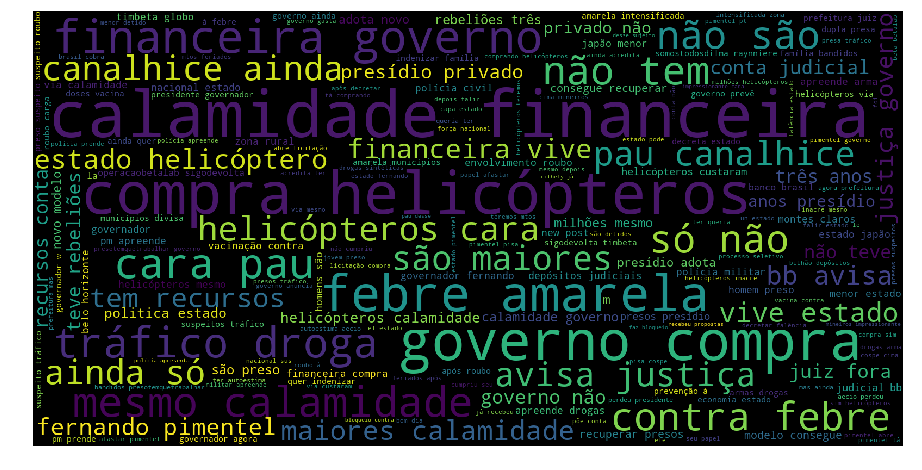

In [10]:
#gera nuvem de palavras após a limpeza da base de treinamento
all_content=' '.join(df_treinamento['text'])
nuvem(all_content)

## Definição dos parâmetros de vetorização (bigrama)

In [181]:
#vectorizer = CountVectorizer(analyzer="word")
vectorizer = CountVectorizer(ngram_range = (1, 2))

## Treinamento

In [182]:
freq_tweets = vectorizer.fit_transform(df_treinamento['text'])
print("Total de palavras aprendidas:", len(vectorizer.vocabulary_))


Total de palavras aprendidas: 20648


## Definição do modelo - Naive Bayes

In [183]:
modelo = MultinomialNB()
modelo.fit(freq_tweets,df_treinamento['sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Avaliação

In [184]:
resultados = cross_val_predict(modelo, freq_tweets, df_treinamento['sentiment'], cv = 10)
print("Acurácia Naive Bayes: ", metrics.accuracy_score(df_treinamento['sentiment'], resultados))

Acurácia Naive Bayes:  0.8927217125382263


## Relatório de classificação

In [159]:
sentimentos = [1, -1, 0]
print(metrics.classification_report(df_treinamento['sentiment'], resultados, sentimentos))

             precision    recall  f1-score   support

          1       0.96      0.89      0.92      3314
         -1       0.88      0.95      0.91      2438
          0       0.83      0.85      0.84      2423

avg / total       0.90      0.89      0.89      8175



## Definição do modelo - Random Forest

In [32]:
#define parâmetros de vetorização - bigrama
vectorizer = CountVectorizer(max_features=1000, ngram_range = (1, 2))                

data_features = vectorizer.fit_transform(df_treinamento['text'])
data_features = data_features.toarray()    

labels = df_treinamento['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=11)

forest = RandomForestClassifier(n_estimators=12, n_jobs=6)

#marca o tempo de treinamento
inicio_forest=time.time()
forest = forest.fit(X_train, y_train)
print("Acurácia Random Forest:", np.mean(cross_val_score(forest, data_features, labels, cv=10)))
fim_forest=time.time()

print("Tempo de treinamento e validação: ", fim_forest-inicio_forest, " segundos")

Acurácia Random Forest: 0.8379249429726567
Tempo de treinamento e validação:  4.849757194519043  segundos


## Carga do dataset de testes

In [185]:
df_resultados=pd.DataFrame([])

tw_rfb = pd.read_csv('D:/Pos_PUC/TCC/Datasets/Teste/toRFB_teste.csv', delimiter=";", encoding='utf-8')
tw_rfb.columns=['id', 'text', 'author_id', 'created_at']
with pd.option_context('display.max_colwidth', -1):     
  display(tw_rfb.sample(n=5, random_state=6))
   

,id,text,author_id,created_at
8733,685046775636471808,@ReceitaFederal Os caracteres anti robô da consulta optantes Simples não está funcionando. FAVOR VERIFICAR URGENTE. Assim desde ontem.,858779556,16/01/07 10:34
11073,129214780799066113,@PortalRFB Alguma previsão para o sistema de consulta de CPF voltar a funcionar? oO,57913023,11/10/26 15:16
1660,1300912735690031105,"@ReceitaFederal @MinEconomia Aguardando REFIS para pessoa física, com os descontos tbm 🙏🏾👍🏾",1138190462559371264,20/09/01 21:45
2028,1281625031521570816,@ReceitaFederal @MPF_PGR https://t.co/9olYtgDAMx,1265647143827750917,20/07/10 16:23
190,1366135224707526664,@ReceitaFederal Muito triste estou. Pq razão estão penalizando pequenas empresas que precisam de refis? Regras novas para arrancar dinheiro de qualquer jeito? P dar auxílio de graça ao invés de nos ajudar p criarmos mais empregos?@jairbolsonaro @PauloGuedesReal,343675805,21/02/28 21:16


## Nuvem da base de testes (sem tratamento)

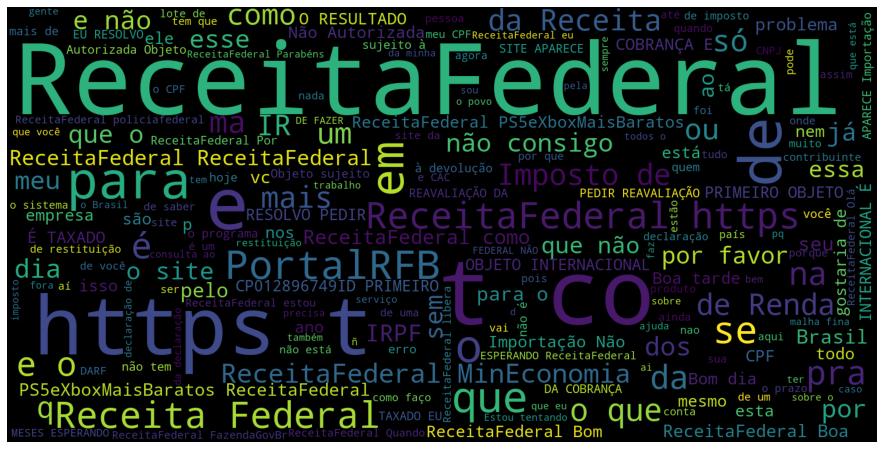

In [49]:
all_content=' '.join(tw_rfb['text'])
nuvem(all_content)

## Tratamento da base de testes

In [186]:
index = tw_rfb[tw_rfb['author_id'] == 18718638].index #remove tweets da RFB
tw_rfb.drop(index, inplace=True)
df_resultados['original']=tw_rfb['text'].copy()
df_resultados['date']=tw_rfb['created_at'].copy()
tw_rfb=limpaTexto(tw_rfb, "text")
testes=tw_rfb['text'].copy()

## Nuvem da base de testes (pós tratamento)

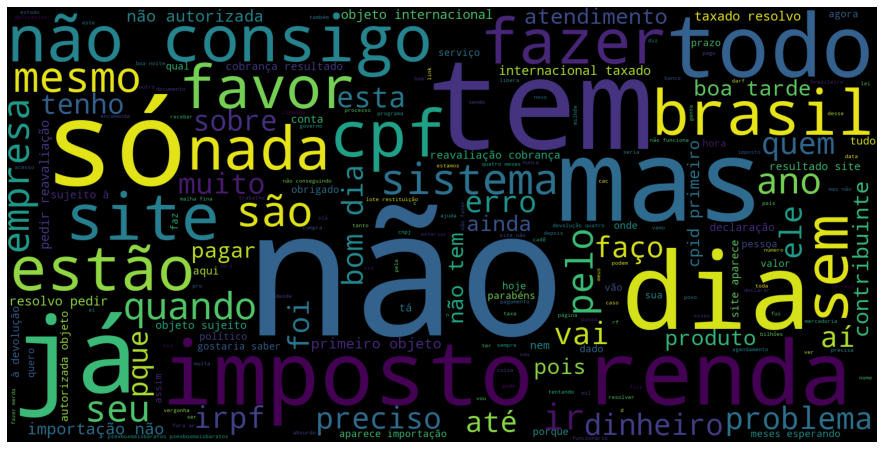

In [51]:
all_content=' '.join(tw_rfb['text'])
nuvem(all_content)

## Deploy do modelo - Naive Bayes

In [187]:
freq_testes = vectorizer.transform(testes)
a=[]
for t, c in zip (testes,modelo.predict(freq_testes)):
    a.append(c)
df_resultados['text']=testes
df_resultados['sentiment']=a    
with pd.option_context('display.max_colwidth', -1):     
  display(df_resultados[['original','text','sentiment']].head())


,original,text,sentiment
0,RT @BrasilAcima_: @ReceitaFederal \nPARTE PRA CIMA DO #COVIDÃO! \n💥💥💥💥💥💥💥\n💥💣💣💣💣💣💥\n💥💣💲💲💲💣💥\n💥💣💲🐀💲💣💥\n💥💣💲💲💲💣💥\n💥💣💣💣💣💣💥\n💥💥💥💥💥💥💥\n#Covid_19MIL \nhttps…,parte cima covidão covid_mil,-1
1,"@ReceitaFederal E quando não é um assunto que se resolva de forma on LINE, e o pessoal que atende não consegue auxiliar, como no caso dos parcelamentos do PERT que foram perdidos, não voltam para os débitos, não permitem renegociar, e ficam constando nas pendências da empresa, qual recomendação?",quando não assunto resolva forma on line pessoal atende não consegue auxiliar caso parcelamentos peque foram perdidos não voltam débitos não permitem renegociar ficam constando pendências empresa qual recomendação,0
2,@ReceitaFederal ira atender os agendados presencialmente?,ira atender agendados presencialmente,1
3,"@ReceitaFederal A Live pode ser acessada, na data do evento, pelo endereço: https://t.co/c2Unm7tRJ0",live pode ser acessada data evento pelo endereço,0
4,"@ReceitaFederal, coloque servidores que saibam abrir e-mails e seus anexos para responder e-mails. Já é a 4ª vez que tenho que explicar a minha solicitação e reenviar toda a documentação pq os servidores não sabem abrir anexos e/ou não sabem ler/interpretar pedidos simples.",coloque servidores saibam abrir mails seus anexos responder mails já ª vez tenho explicar solicitação reenviar toda documentação pque servidores não sabem abrir anexos não sabem ler interpretar pedidos simples,0


## Resultados

In [65]:
df_resultados['sentiment'].count()

11292

In [66]:
df_resultados['sentiment'].value_counts(normalize=True)

-1    0.479543
 0    0.327666
 1    0.192791
Name: sentiment, dtype: float64

In [117]:
#amostra aleatória de 10 registros classificados como negativos no mês de janeiro de 2021.
with pd.option_context('display.max_colwidth', -1):     
  display(df_resultados[['original','date']].loc[(df_resultados['sentiment']==-1) & \
                                                        (df_resultados['date']>="21/01/01") &\
                                                        (df_resultados['date']<="21/01/31")].sample(n=10, random_state=2))

,original,date
322,@ReceitaFederal Fiz a compra de um livro no exterior e está na alfândega aguardando pagamento! Livros não são isentos de impostos???? Aguardo resposta.,21/01/30 03:41
380,"@ReceitaFederal tenho um produto nos correios parado em Curitiba desde do dia 05/01 com status encaminhado para fiscalização meu produto foi lá sendo tratado como lixo, os correios serviço de lixo não resolvem nada. É a ETC ou a RFB responsável pela fiscalização ?",21/01/19 11:27
445,"@ReceitaFederal Não consigo usar o sistema SAL para gerar contribuição individual para 01/2021, alguma previsão para resolver o problema? - diz que o valor do salário não é reconhecido.",21/01/06 14:51
383,@ReceitaFederal @cfcbsb \n@PauloGuedesReal \nEntão vai ter solução? Já há centenas de reclamações nas ouvidorias da RFB. DAS é arrecadação caso não saibam serve para pagar o salario de vocês também. Esse inferno esta dando erro desde o inicio da semana passada. Pretendem resolver?,21/01/18 20:15
407,"@ReceitaFederal Eu gostaria de saber cadê a porra do item que eu comprei meses atrás e que vocês não só seguraram sem motivo nenhum ainda passam da porra do prazo de 30 dias para fazer a maldita análise, JÁ SE PASSARAM 44 DIAS PORRA",21/01/16 03:06
340,"@ReceitaFederal @tcu\nEssas notas fiscais no portal, são quentes?????\nhttps://t.co/COsOeRoY8G",21/01/27 17:58
428,@receitafederal muita burocracia!!! A segunda via da declaração do imposto de renda do ano de 2018 é impossível!,21/01/11 17:03
434,"@ReceitaFederal @ReceitaFederal peçam aos desenvolvedores do EFD-Contribuições para alterarem o município de Mogi-Mirim. Esta escrito Moji, o que causa erro na validação do arquivo importado.",21/01/09 14:55
425,"@ReceitaFederal Amados, estamos com um erro no download do arquivo do Programa Gerador da Declaração Dirf 2021. Poderiam verificar pra nós?",21/01/12 17:08
378,@ReceitaFederal faz a porra de um site decente seus filhosdaputa,21/01/19 16:13


## Gravação dos resultados

In [55]:
df_resultados.to_csv("D:/Pos_PUC/TCC/Datasets/resultado.csv")